In [2]:
#--- 
import pandas as pd
import numpy as np
#---
import re
from unidecode import unidecode
#---
import matplotlib.pyplot as plt
import seaborn as sns
#--- Scraping
import requests
from bs4 import BeautifulSoup

#---
import os
import requests
import gzip
import shutil
from tqdm import tqdm

import datetime
from datetime import timedelta, date
import math
import requests
from bs4 import BeautifulSoup
from pathlib import Path

In [ ]:
def scrape_simiestros_urls():
    # fetch HTML content
    url = 'https://data.buenosaires.gob.ar/dataset/victimas-siniestros-viales'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
   
    return soup
#res =scrape_simiestros_urls()
#print(res)

In [ ]:
import requests
from bs4 import BeautifulSoup

def scrape_siniestros_urls():
    # URL de la página con los datasets
    url = 'https://data.buenosaires.gob.ar/dataset/victimas-siniestros-viales'
    response = requests.get(url)

#Parsea el contenido HTML de la respuesta
    soup = BeautifulSoup(response.content, 'html.parser')

#Busca todos los elementos <a> con un atributo href
    links = soup.find_all('a')

#Inicializa un diccionario vacío para almacenar los nombres de archivo y las URLs
    file_urls = {}

#Filtra y extrae las URLs de los archivos .zip y otros formatos deseados
    for link in links:
        href = link.get('href')
        if href and href.endswith(('.zip', '.xlsx', '.csv', '.gz', '.geojson','.pdf')):
            # Extrae el nombre del archivo de la URL
            file_name = href.split('/')[-1]
            # Añade al diccionario
            file_urls[file_name] = href

    return file_urls

#Llama a la función y muestra los resultados
file_urls_dict = scrape_siniestros_urls()
for name, url in file_urls_dict.items():
    print(f'{name}: {url}')


In [ ]:


class DatasetDownloader:
    def __init__(self, base_url, download_folder):
        self.base_url = base_url
        self.download_folder = Path(download_folder)
        # Make sure the download directory exists
        self.download_folder.mkdir(parents=True, exist_ok=True)

    def scrape_siniestros_urls(self):
        response = requests.get(self.base_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        links = soup.find_all('a')

        file_urls = {}
        for link in links:
            href = link.get('href')
            if href and href.endswith(('.zip', '.xlsx', '.csv', '.gz', '.geojson', '.pdf')):
                file_name = href.split('/')[-1]
                file_urls[file_name] = href
        return file_urls

    def download_file(self, url, save_path):
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Archivo guardado: {save_path}")
        except Exception as e:
            print(f"Error al descargar el archivo: {url}")
            print(f"Error details: {e}")

    def download_datasets(self):
        file_urls_dict = self.scrape_siniestros_urls()
        for file_name, url in file_urls_dict.items():
            save_path = self.download_folder / file_name
            self.download_file(url, save_path)

# Example usage
base_url = 'https://data.buenosaires.gob.ar/dataset/victimas-siniestros-viales'

base_url2 = 'https://data.buenosaires.gob.ar/dataset/comunas'

download_folder = '../datasets/raw'
downloader = DatasetDownloader(base_url, download_folder)
downloader.download_datasets()
downloader = DatasetDownloader(base_url2, download_folder)
downloader.download_datasets()

## Importación de Datos

In [7]:
homicidios = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'HECHOS', engine='openpyxl')
victima_h = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'VICTIMAS',  engine='openpyxl')
comunas_h = pd.read_excel('../datasets/raw/comunas.xlsx' , sheet_name = 'comunas',  engine='openpyxl')
lesiones = pd.read_excel('../datasets/raw/lesiones.xlsx' , sheet_name = 'HECHOS',  engine='openpyxl')
victima_l = pd.read_excel('../datasets/raw/lesiones.xlsx' , sheet_name = 'VICTIMAS',  engine='openpyxl')
# Revsisón de Modelo de datos
homicidios.name = 'homicidios'
victima_h.name = 'victima_h'
comunas_h.name = 'comunas_h'
lesiones.name = 'lesiones'
victima_l.name = 'victima_l'



In [8]:
pd.set_option('display.max_columns', None)

### EDA (Exploración, transfromación y Modelado)

In [9]:

dataframes = [homicidios, victima_h, comunas_h, lesiones, victima_l]

# for df in dataframes:
#     print(f"Dataframe {df.name}:\nRegistros {df.shape[0]} y Columnas {df.shape[1]}\n\n{df.head(3)} \n\n\n")

In [ ]:
for df in dataframes:
    print(f"Valores únicos en el DataFrame {df.name}:\n")
    
    for column in df.columns:
        unique_values = df[column].unique()[:5]
        print(f"Columna: {column}, Valores únicos: {unique_values}\n")
    
    print("\n\n\n")

### Análisis de Valores Faltantes

In [10]:
#dataframes = [homicidios, victima_h, comunas_h, lesiones, victima_l]

# Crear un DataFrame para almacenar la información sobre valores raros
reg_valores_raros = pd.DataFrame(columns=['Nombre DataFrame', 'Nombre Columna', 'Tipo de Dato', 'Total Valores', 'Total Nulos', 'Total Raros', 'Valores Faltantes %'])

# Definir qué valores consideras "raros"
valores_raros = ['SD', 'No especificado', 'sd' , '', 'Point (. .)']

# Iterar sobre cada DataFrame
for df in dataframes:
    # Iterar sobre cada columna del DataFrame
    for columna in df.columns:
        # Obtener información de cada columna
        nombre_df = df.name
        nombre_columna = columna
        tipo_dato = df[columna].dtype
        total_valores = len(df)
        total_nulos = df[columna].isnull().sum()
        total_raros = df[columna].isin(valores_raros).sum()
        total_nulos_y_raros = total_nulos + total_raros
        porcentaje_raros = ((total_nulos + total_raros )/ total_valores) * 100

        # Agregar la información al DataFrame de resumen
        reg_valores_raros.loc[len(reg_valores_raros)] = [nombre_df, nombre_columna, tipo_dato, total_valores, total_nulos, total_raros,  porcentaje_raros]

# Filtrar el DataFrame para mostrar solo las filas con 'Total Raros' mayor que cero
reg_valores_raros_c = reg_valores_raros[reg_valores_raros['Valores Faltantes %'] > 0]


"""
# Contar los valores únicos y su frecuencia en la columna 'GRAVEDAD'
conteo_gravedad = victima_l['GRAVEDAD'].value_counts()
# Mostrar el resultado
print(conteo_gravedad)
"""
# Ordenar el DataFrame por 'Valores Faltantes %' de forma descendente
reg_valores_raros_c = reg_valores_raros_c.sort_values(by='Valores Faltantes %', ascending=False)

# Mostrar el DataFrame ordenado
reg_valores_raros_c.head(50)

,Nombre DataFrame,Nombre Columna,Tipo de Dato,Total Valores,Total Nulos,Total Raros,Valores Faltantes %
72,victima_l,GRAVEDAD,object,27605,0,27068,98.054700
63,lesiones,gravedad,object,23785,0,23139,97.284003
11,homicidios,Altura,float64,696,567,0,81.465517
48,lesiones,otra_direccion,object,23785,0,18295,76.918226
56,lesiones,acusado,object,23785,0,15288,64.275804
51,lesiones,cruce,object,23785,14378,0,60.449863
69,victima_l,VEHICULO_VICTIMA,object,27605,0,16272,58.945843
61,lesiones,camion,object,23785,93,12708,53.819634
59,lesiones,auto,object,23785,93,12543,53.125920
60,lesiones,transporte_publico,object,23785,93,11801,50.006306


In [ ]:
# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar barras apiladas para valores nulos y raros
barras = ax.bar(reg_valores_raros_c['Nombre Columna'], reg_valores_raros_c['Total Nulos'], label='Valores Nulos')
barras_raros = ax.bar(reg_valores_raros_c['Nombre Columna'], reg_valores_raros_c['Total Raros'], bottom=reg_valores_raros_c['Total Nulos'], label='Valores Raros')

# Configurar etiquetas y título
ax.set_xlabel('Campos')
ax.set_ylabel('Cantidad')
ax.set_title('Valores Nulos y Valores Raros')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Agregar leyenda
ax.legend()

# Ajustar el espaciado entre subgráficos
plt.subplots_adjust(bottom=0.3)

# Obtener las 7 barras más altas
alturas_barras = [bar.get_height() for bar in barras]
alturas_barras_raros = [bar.get_height() for bar in barras_raros]
alturas_totales = [x + y for x, y in zip(alturas_barras, alturas_barras_raros)]
indices_mayores = sorted(range(len(alturas_totales)), key=lambda x: alturas_totales[x], reverse=True)[:7]

# Agregar etiquetas con porcentajes a las 7 barras más altas
for i, indice in enumerate(indices_mayores):
    altura_total = alturas_totales[indice]
    porcentaje = altura_total / reg_valores_raros_c['Total Valores'].iloc[indice] * 100
    ax.text(indice, altura_total + 0.01 * reg_valores_raros_c['Total Valores'].max(), f"{porcentaje:.2f}%", ha='center', va='bottom')

# Mostrar el gráfico
plt.show()

### PreProcesado de datos

In [29]:
# Función para limpiar y formatear los nombres de las columnas
def limpiar_nombre(nombre):
    # Eliminar caracteres especiales y espacios
    nombre = re.sub(r'\W+', '_', nombre)
    # Eliminar acentos
    nombre = unidecode(nombre)
    # Convertir a minúsculas
    nombre = nombre.lower()
    return nombre

def limpiar_nombres_columnas(df):
    df.columns = [limpiar_nombre(col) for col in df.columns]

# Aplicar la función limpiar_nombres_columnas a cada DataFrame
for df in dataframes:
    limpiar_nombres_columnas(df)

# Imprimir los nombres de las columnas limpias para cada DataFrame
for df in dataframes:
    print(f"Columnas de {df.name}:")
    print(df.columns)
    print()

Columnas de homicidios:
Index(['id', 'n_victimas', 'fecha', 'aaaa', 'mm', 'dd', 'hora', 'hh',
       'lugar_del_hecho', 'tipo_de_calle', 'calle', 'altura', 'cruce',
       'direccion_normalizada', 'comuna', 'xy_caba_', 'pos_x', 'pos_y',
       'participantes', 'victima', 'acusado'],
      dtype='object')

Columnas de victima_h:
Index(['id_hecho', 'fecha', 'aaaa', 'mm', 'dd', 'rol', 'victima', 'sexo',
       'edad', 'fecha_fallecimiento'],
      dtype='object')

Columnas de comunas_h:
Index(['id', 'objeto', 'comunas', 'barrios', 'perimetro', 'area'], dtype='object')

Columnas de lesiones:
Index(['id', 'n_victimas', 'aaaa', 'mm', 'dd', 'fecha', 'hora', 'franja_hora',
       'direccion_normalizada', 'comuna', 'tipo_calle', 'otra_direccion',
       'calle', 'altura', 'cruce', 'geocodificacion_caba', 'longitud',
       'latutid', 'victima', 'acusado', 'participantes', 'moto', 'auto',
       'transporte_publico', 'camion', 'ciclista', 'gravedad'],
      dtype='object')

Columnas de victima_l

In [30]:
def reemplazar_nulos_y_raros(dataframes, valores_raros):
    dataframes_limpios = []

    for df in dataframes:
        # Reemplazar los valores raros con NaN
        df = df.replace(valores_raros, pd.NaT)

        # Reemplazar los valores nulos con NaN
        df = df.replace('', pd.NaT)

        dataframes_limpios.append(df)

    return dataframes_limpios

dataframes = [homicidios, victima_h, comunas_h, lesiones, victima_l]
# Definir qué valores consideras "raros"
valores_raros = ['SD', 'No especificado', 'sd' , '']
# Ejemplo de uso
# Supongamos que tienes una lista de DataFrames llamada 'dataframes' y 'valores_raros' es la lista de valores raros
dataframes_limpios = reemplazar_nulos_y_raros(dataframes, valores_raros)

# Puedes asignar cada DataFrame tratado a una variable separada
homicidios_l, victima_h_l, comunas_h_l, lesiones_l, victima_l_l = dataframes_limpios

In [31]:
homicidios_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     696 non-null    object        
 1   n_victimas             696 non-null    int64         
 2   fecha                  696 non-null    datetime64[ns]
 3   aaaa                   696 non-null    int64         
 4   mm                     696 non-null    int64         
 5   dd                     696 non-null    int64         
 6   hora                   695 non-null    object        
 7   hh                     695 non-null    object        
 8   lugar_del_hecho        695 non-null    object        
 9   tipo_de_calle          696 non-null    object        
 10  calle                  695 non-null    object        
 11  altura                 129 non-null    float64       
 12  cruce                  525 non-null    object        
 13  direc

In [32]:
def procesar_dataframe(df):
    # Convertir la columna de fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Crear nuevas columnas para año, mes y día
    df['anio'] = df['fecha'].dt.year
    df['mes'] = df['fecha'].dt.month
    df['dia'] = df['fecha'].dt.day

    # Llenar los valores nulos en 'hora' con '00:00:00'
    df['hora'] = df['hora'].fillna('00:00:00')


    # Convertir 'hora' a formato datetime
    df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S')

    # Crear una nueva columna para fecha y hora combinadas
    df['fecha_hora'] = pd.to_datetime(dict(
        year=df['anio'],
        month=df['mes'],
        day=df['dia'],
        hour=df['hora'].dt.hour,
        minute=df['hora'].dt.minute
    ))

    # Eliminar columnas innecesarias
    columns_to_drop = ['fecha', 'aaaa', 'mm', 'dd', 'hh','hora','altura']
    df = df.drop(columns=columns_to_drop)

    # Crear columnas formateadas para fecha y hora
    df['fecha_formato'] = df['fecha_hora'].dt.strftime('%Y-%m-%d')
    df['hora_formato'] = df['fecha_hora'].dt.strftime('%H:%M')
    df['hora_i'] = df['fecha_hora'].dt.strftime('%H')
    df['hora_i'] = df['hora_i'].astype('int')

    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'df'
homicidios_l = procesar_dataframe(homicidios_l.copy())


In [33]:
def procesar_homicidios_l(df):
    
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    
    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
homicidios_l = procesar_homicidios_l(homicidios_l.copy())

In [34]:
def procesar_homicidios_lm(df):
    valid_positions = ~(df['pos_x'].str.contains('[^0-9.,-]') | df['pos_y'].str.contains('[^0-9.,-]') | (df['pos_x'] == '.') | (df['pos_y'] == '.'))

    # Establecer posiciones no válidas en NaN
    df.loc[~valid_positions, ['pos_x', 'pos_y']] = np.nan

    # Convertir las cadenas a tipo numérico (float)
    df['pos_x'] = df['pos_x'].str.replace(',', '.').astype(float)
    df['pos_y'] = df['pos_y'].str.replace(',', '.').astype(float)
    return df
def extraer_coordenadas(texto):
    # Utilizamos una expresión regular para extraer las coordenadas
    coordenadas = re.findall(r'\d+\.\d+', texto)
    if len(coordenadas) == 2:
        return float(coordenadas[0]), float(coordenadas[1])
    else:
        return None, None

homicidios_lm = procesar_homicidios_lm(homicidios_l)
# Aplicar la función a la columna 'XY (CABA)'
homicidios_lm['coordenada_x'], homicidios_lm['coordenada_y'] = zip(*homicidios_lm['xy_caba_'].map(extraer_coordenadas))


In [35]:
homicidios_lm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     696 non-null    object        
 1   n_victimas             696 non-null    int64         
 2   lugar_del_hecho        696 non-null    object        
 3   tipo_de_calle          696 non-null    object        
 4   calle                  696 non-null    object        
 5   cruce                  696 non-null    object        
 6   direccion_normalizada  696 non-null    object        
 7   comuna                 696 non-null    int64         
 8   xy_caba_               696 non-null    object        
 9   pos_x                  684 non-null    float64       
 10  pos_y                  684 non-null    float64       
 11  participantes          696 non-null    object        
 12  victima                696 non-null    object        
 13  acusa

In [86]:
def procesar_victima_h_l(df):
    # Llenar los valores nulos en 'fecha_fallecimiento' con 'fecha' + 7 días
    df['fecha_fallecimiento'] = df['fecha_fallecimiento'].combine_first(df['fecha'] + pd.DateOffset(days=7))
    
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    
    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
victima_h_l = procesar_victima_h_l(victima_h_l.copy())

In [87]:
victima_h_l.head(5)

,id_hecho,fecha,aaaa,mm,dd,rol,victima,sexo,edad,fecha_fallecimiento
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,2016-01-17 00:00:00
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00


In [36]:
victima_h_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_hecho             717 non-null    object        
 1   fecha                717 non-null    datetime64[ns]
 2   aaaa                 717 non-null    int64         
 3   mm                   717 non-null    int64         
 4   dd                   717 non-null    int64         
 5   rol                  706 non-null    object        
 6   victima              708 non-null    object        
 7   sexo                 711 non-null    object        
 8   edad                 664 non-null    object        
 9   fecha_fallecimiento  649 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


In [37]:
dataNumericas = homicidios_lm.select_dtypes(include=['number']) 
dataNumericas.describe()

,n_victimas,comuna,pos_x,pos_y,anio,mes,dia,hora_i,coordenada_x,coordenada_y
count,696.000000,696.000000,684.000000,684.000000,696.000000,696.000000,696.000000,696.000000,682.000000,682.000000
mean,1.030172,7.425287,-58.441545,-34.619632,2018.188218,6.692529,15.935345,11.640805,101990.962338,101078.485362
std,0.179393,4.387050,0.046144,0.035289,1.683754,3.571309,8.641883,6.709834,4230.329590,3914.622909
min,1.000000,0.000000,-58.529942,-34.705250,2016.000000,1.000000,1.000000,0.000000,93889.867899,91571.233073
25%,1.000000,4.000000,-58.476218,-34.643689,2017.000000,4.000000,9.000000,6.000000,98807.750321,98407.889777
50%,1.000000,8.000000,-58.444513,-34.622928,2018.000000,7.000000,16.000000,11.000000,101721.590022,100708.189095
75%,1.000000,11.000000,-58.401841,-34.596799,2020.000000,10.000000,23.000000,17.250000,105630.884244,103634.991834
max,3.000000,15.000000,-58.356082,-34.534654,2021.000000,12.000000,31.000000,23.000000,109831.098614,110496.053085


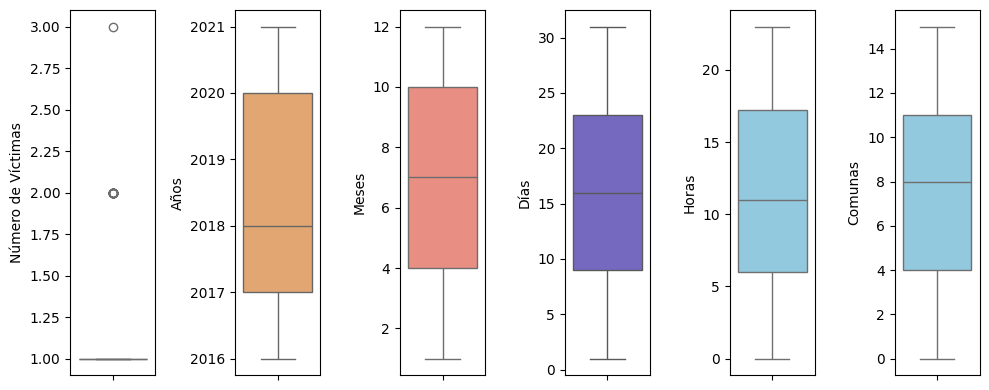

In [38]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 4))

# Crear subplots para los gráficos 
plt.subplot(1, 6, 1) 
sns.boxplot(data=homicidios_lm, y='n_victimas', color = "#FA8072")
plt.ylabel('Número de Víctimas')

plt.subplot(1, 6, 2) 
sns.boxplot(data=homicidios_lm, y='anio', color = "#F4A460")
plt.ylabel('Años')

plt.subplot(1, 6, 3) 
sns.boxplot(data=homicidios_lm, y='mes', color = "#FA8072")
plt.ylabel('Meses')

plt.subplot(1, 6, 4) 
sns.boxplot(data=homicidios_lm, y='dia', color = "#6A5ACD")
plt.ylabel('Días')

plt.subplot(1, 6, 5) 
sns.boxplot(data=homicidios_lm, y='hora_i', color = "#87CEEB")
plt.ylabel('Horas')

plt.subplot(1, 6, 6) 
sns.boxplot(data=homicidios_lm, y='comuna', color = "#87CEEB")
plt.ylabel('Comunas')
# Ajustar espaciado entre subplots
plt.tight_layout()

plt.show()

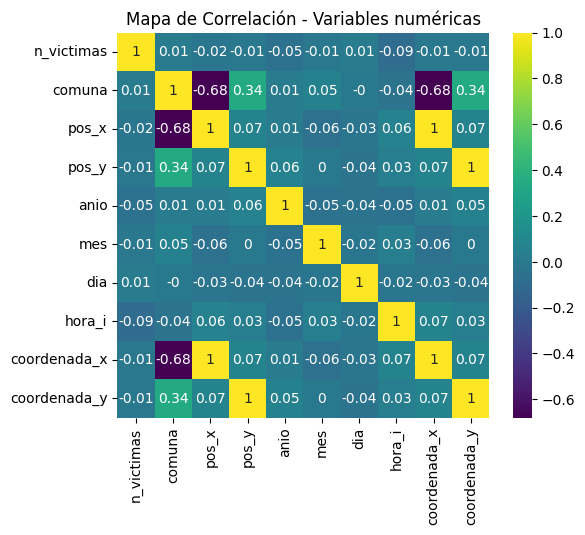

In [39]:
# Generamos un mapa de calor con las correlaciones de los todos los datos que contengan números 
dataNumerica = homicidios_lm.select_dtypes(include=['number']) 
corr = dataNumerica.corr().round(2)

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="viridis", annot=True)
plt.title('Mapa de Correlación - Variables numéricas')
plt.show()

C:\Users\ozi\AppData\Local\Temp\ipykernel_5292\353363437.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_filtrado, x='n_victimas', palette="Paired")


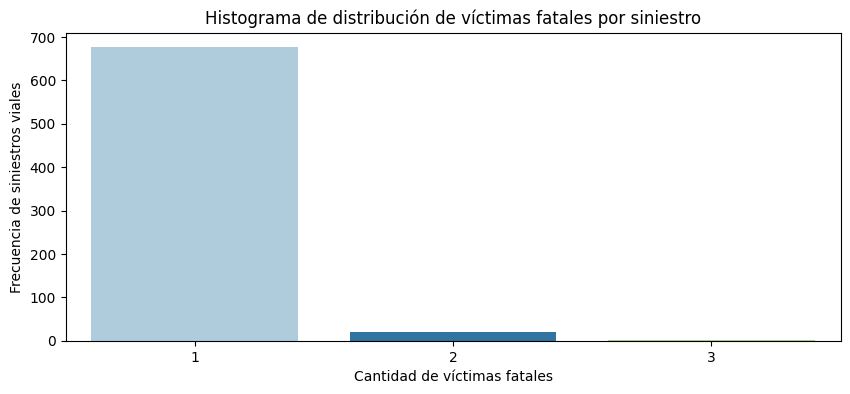

In [40]:
plt.figure(figsize=(10, 4))
# se filtran los valores sin datos o nulos 
df_filtrado = homicidios_lm[homicidios_lm["n_victimas"] != 0]

#Se cuentan los datos de la columna y se calcula la frecuencia en que se distribuye
sns.countplot(df_filtrado, x='n_victimas', palette="Paired")

plt.ylabel("Frecuencia de siniestros viales")
plt.xlabel("Cantidad de víctimas fatales")
plt.title("Histograma de distribución de víctimas fatales por siniestro")

plt.show()

In [ ]:
homicidios_lm.info()

In [41]:
# Agrupar por año y mes, y sumar el número de víctimas
rel_tiempo = homicidios_lm.groupby(['anio', 'mes'])['n_victimas'].sum().reset_index()
# Combinar AÑO y MES para obtener una sola variable de tiempo, creando la columna "Fecha" como str
rel_tiempo["fecha"] = rel_tiempo["anio"].astype(str) + '-' + rel_tiempo["mes"].astype(str)
# Convertir la variable de tiempo a formato datetime
rel_tiempo["fecha"] = pd.to_datetime(rel_tiempo["fecha"])
rel_tiempo.head(5)

,anio,mes,n_victimas,fecha
0,2016,1,8,2016-01-01
1,2016,2,12,2016-02-01
2,2016,3,13,2016-03-01
3,2016,4,11,2016-04-01
4,2016,5,7,2016-05-01


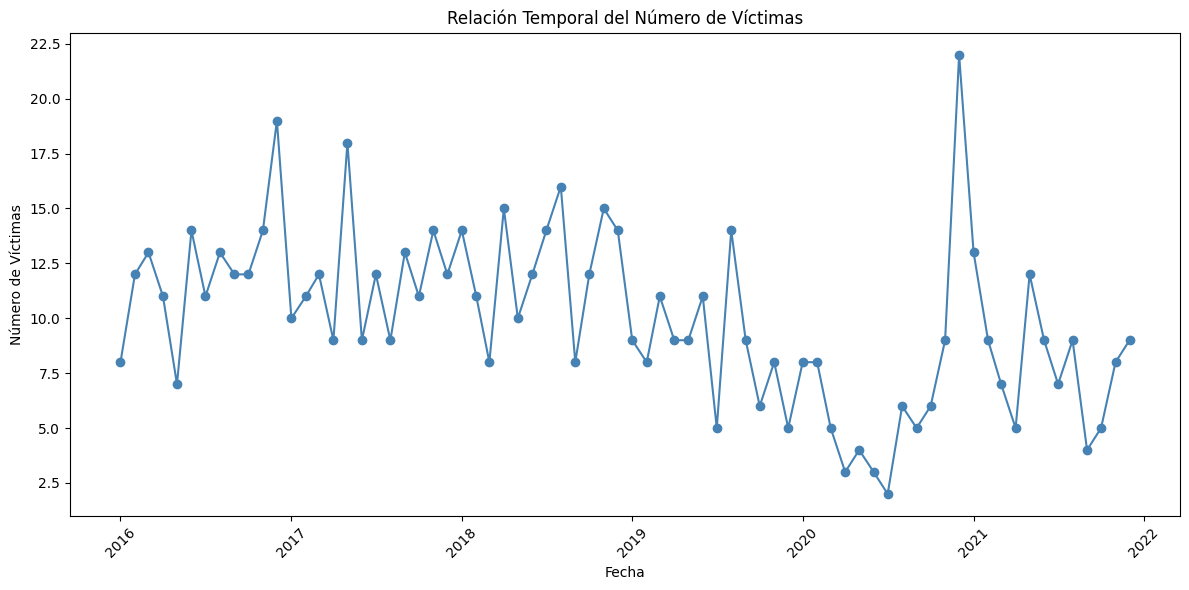

In [42]:
# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(rel_tiempo["fecha"], rel_tiempo["n_victimas"], marker='o', color='steelblue')

# Añadir títulos y etiquetas
plt.title('Relación Temporal del Número de Víctimas')
plt.xlabel('Fecha')
plt.ylabel('Número de Víctimas')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

C:\Users\ozi\AppData\Local\Temp\ipykernel_5292\3730978411.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='mes', y='n_victimas', data=data, palette="winter")


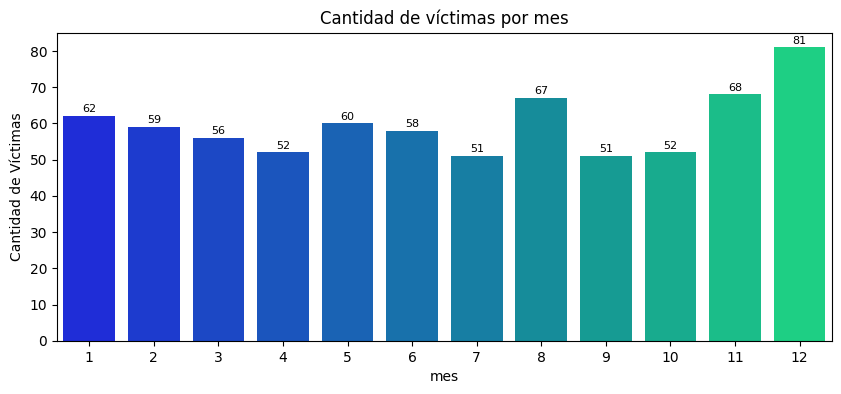

In [44]:
# Se agrupa por la cantidad de víctimas por mes
data = homicidios_lm.groupby(['mes'])['n_victimas'].sum().reset_index()
data["mes"]=data["mes"].astype("Int64")

# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='mes', y='n_victimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por mes')
ax.set_xlabel('mes') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

In [46]:
data.n_victimas.sum()


717

C:\Users\ozi\AppData\Local\Temp\ipykernel_5292\1403679157.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='dia', y='n_victimas', data=data, palette="winter")


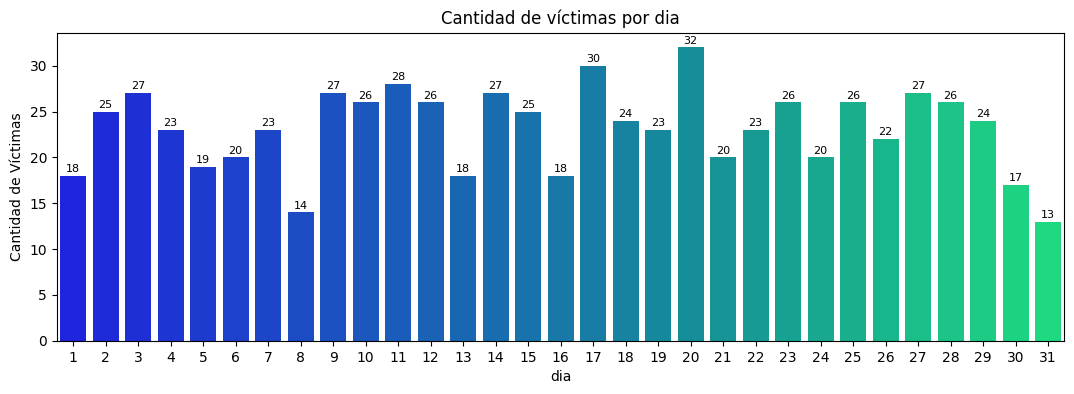

In [48]:
# Se agrupa por la cantidad de víctimas por dia
data = homicidios_lm.groupby(['dia'])['n_victimas'].sum().reset_index()
data["dia"]=data["dia"].astype("Int64")

# Se grafica
plt.figure(figsize=(13,4))

ax = sns.barplot(x='dia', y='n_victimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por dia')
ax.set_xlabel('dia') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

In [67]:
# Se agrupa por la cantidad de víctimas por fecha_formato
data = homicidios_lm.groupby(['fecha_hora'])['n_victimas'].sum().reset_index()
#data["fecha_formato"]=data["fecha_formato"].astype("Int64")
#Creo una columna nueva `Día semana` que contenga el nombre del día de la semana
data['dia_sem'] = data['fecha_hora'].dt.strftime('%A')
#Creo un diccionario para modificar a español los nombres de los dás de la semana y lo aplico a la columna nueva
dic={  'Friday':'Viernes',
       'Saturday': 'Sabado',
       'Sunday': 'Domingo',  
       'Thursday': 'Jueves',
        'Monday': 'Lunes',
        'Wednesday': 'Miercoles',
       'Tuesday': 'Martes'}
data['dia_sem'] =data['dia_sem'].replace(dic)
# Eliminar columnas innecesarias
columns_to_drop = ['fecha_hora']
data = data.drop(columns=columns_to_drop)
data2 = data.groupby(['dia_sem'])['n_victimas'].sum().reset_index()


In [70]:
data2

,dia_sem,n_victimas
0,Domingo,105
1,Jueves,96
2,Lunes,107
3,Martes,101
4,Miercoles,99
5,Sabado,107
6,Viernes,102


In [62]:
data.dia_sem.unique()

array(['Viernes', 'Sabado', 'Domingo', 'Jueves', 'Lunes', 'Miercoles',
       'Martes'], dtype=object)

C:\Users\ozi\AppData\Local\Temp\ipykernel_5292\3693204532.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='dia_sem', y='n_victimas', data=data2, palette="winter")


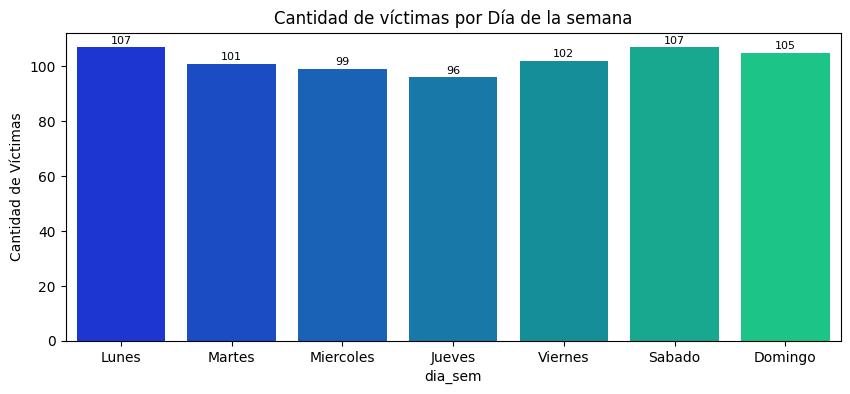

In [71]:
# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'orden_sem' en el DataFrame para representar el orden numérico de los días de la semana
data2['orden_sem'] = data2['dia_sem'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data2 = data2.sort_values(by='orden_sem')



# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='dia_sem', y='n_victimas', data=data2, palette="winter")
ax.set_title('Cantidad de víctimas por Día de la semana')
ax.set_xlabel('dia_sem') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico cambiar a semestre ? 
plt.show()

In [74]:
# Se agrupa por la cantidad de víctimas por fecha_formato
data = homicidios_lm.groupby(['fecha_hora'])['n_victimas'].sum().reset_index()
#data["fecha_formato"]=data["fecha_formato"].astype("Int64")
#Creo una columna nueva `Día semana` que contenga el nombre del día de la semana
data['dia_sem'] = data['fecha_hora'].dt.strftime('%A')
data['hora'] = data['fecha_hora'].dt.hour

#Creo un diccionario para modificar a español los nombres de los dás de la semana y lo aplico a la columna nueva
dic={  'Friday':'Viernes',
       'Saturday': 'Sabado',
       'Sunday': 'Domingo',  
       'Thursday': 'Jueves',
        'Monday': 'Lunes',
        'Wednesday': 'Miercoles',
       'Tuesday': 'Martes'}
data['dia_sem'] =data['dia_sem'].replace(dic)
# Eliminar columnas innecesarias
columns_to_drop = ['fecha_hora']
data = data.drop(columns=columns_to_drop)
data2 = data.groupby(['dia_sem','hora'])['n_victimas'].sum().reset_index()


In [76]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dia_sem     162 non-null    object
 1   hora        162 non-null    int32 
 2   n_victimas  162 non-null    int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 3.3+ KB


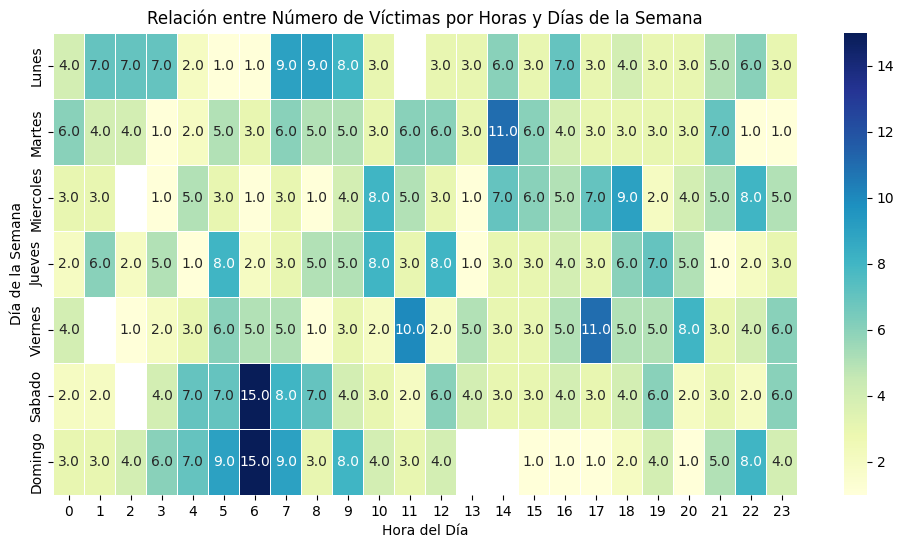

In [78]:
# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'orden_sem' en el DataFrame para representar el orden numérico de los días de la semana
data2['orden_sem'] = data2['dia_sem'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data2 = data2.sort_values(by='orden_sem')

# Crear una tabla pivot para los datos
pivot_data = data2.pivot_table(index= 'dia_sem', columns='hora', values='n_victimas', aggfunc='sum')
pivot_data = pivot_data.reindex(orden_dias_semana)

# Crear un mapa de calor (heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=0.5)

# Configurar etiquetas y título
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Relación entre Número de Víctimas por Horas y Días de la Semana')

# Mostrar el gráfico
plt.show()


In [80]:
victima_h_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_hecho             717 non-null    object        
 1   fecha                717 non-null    datetime64[ns]
 2   aaaa                 717 non-null    int64         
 3   mm                   717 non-null    int64         
 4   dd                   717 non-null    int64         
 5   rol                  706 non-null    object        
 6   victima              708 non-null    object        
 7   sexo                 711 non-null    object        
 8   edad                 664 non-null    object        
 9   fecha_fallecimiento  649 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


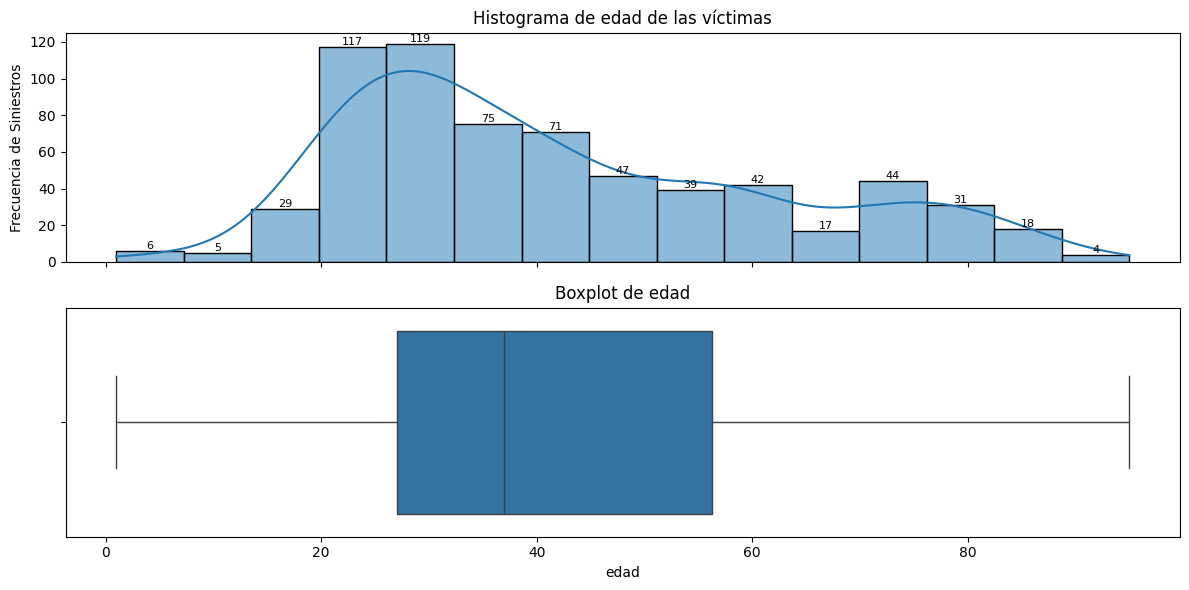

In [81]:
df = victima_h_l.copy()
# Se crea una figura con un solo eje x compartido para tener dos gráficos en uno
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Se grafica el histograma de la edad
sns.histplot(df['edad'], kde=True, ax=ax[0]) #se agrega la línea de suavizado
ax[0].set_title('Histograma de edad de las víctimas') ; ax[0].set_ylabel('Frecuencia de Siniestros')

# Agregar etiquetas de datos en el histograma
for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black')

# Se grafica el boxplot de la edad
sns.boxplot(x=df['edad'], ax=ax[1])
ax[1].set_title('Boxplot de edad') ; ax[1].set_xlabel('edad')

# Se ajusta y muestra el gráfico
plt.tight_layout()
plt.show()

In [83]:
victima_h_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_hecho             717 non-null    object        
 1   fecha                717 non-null    datetime64[ns]
 2   aaaa                 717 non-null    int64         
 3   mm                   717 non-null    int64         
 4   dd                   717 non-null    int64         
 5   rol                  706 non-null    object        
 6   victima              708 non-null    object        
 7   sexo                 711 non-null    object        
 8   edad                 664 non-null    object        
 9   fecha_fallecimiento  649 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


In [84]:
victima_h_l.head(15)

,id_hecho,fecha,aaaa,mm,dd,rol,victima,sexo,edad,fecha_fallecimiento
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,NaT
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00
5,2016-0008,2016-01-24,2016,1,24,CONDUCTOR,MOTO,MASCULINO,30,2016-01-24 00:00:00
6,2016-0009,2016-01-24,2016,1,24,PASAJERO_ACOMPAÑANTE,MOTO,MASCULINO,29,2016-01-26 00:00:00
7,2016-0010,2016-01-29,2016,1,29,CONDUCTOR,MOTO,MASCULINO,18,2016-01-29 00:00:00
8,2016-0012,2016-02-08,2016,2,8,CONDUCTOR,MOTO,MASCULINO,22,2016-02-08 00:00:00
9,2016-0013,2016-02-10,2016,2,10,PEATON,PEATON,MASCULINO,16,2016-02-10 00:00:00


In [82]:
df = victima_h_l.copy()
#Agrupa los datos en cantidad de victimas por edad y horas 
data = df.groupby(['edad', "hora", "sexo"])['Num víctimas'].sum().reset_index()
data["edad"]=data["edad"].astype("Int64")
data["hora"]=data["hora"].astype("Int64")

# Crear un gráfico de dispersión para la relación entre edad, hora y sexo
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='edad', y='hora', hue='sexo', alpha=0.5, palette='tab10', s=100)

# Agregar etiquetas a los ejes
plt.xlabel('edad de las Víctimas')
plt.ylabel('hora del Siniestro')
plt.title('Relación entre edad de las Víctimas, hora del Siniestro y sexo')

# Agregar una leyenda
plt.legend(title='sexo')

# Mostrar el gráfico
plt.show()

KeyError: 'hora'